# Lab4 Intro
Now that you have classified the Voice of Customers into categories in the previous experiment, you can use Generative AI techniques to write analysis report for you further.

### Your objectives are:

- Explore the statistical results of classification
- Write a summary analysis report
- Tuning the prompt instruction to enhance the report

## 1. Install dependencies

In [ ]:
!pip install -Uq boto3 langchain==0.2.16 langchain_aws==0.1.17 pandas openpyxl termcolor

## 2. Initialize Bedrock model using LangChain

We will continue to use Amazon Titan Model to help generate analysis for the result. Different from Lab 1, here we apply the ChatBedrockConverse object which provides a unified conversational interface for Bedrock models.
- We use [Langchain](https://www.langchain.com/) SDK to build the application
- Initialize a ChatBedrockConverse object with Amzon Titan Text model with the model id "amazon.titan-text-premier-v1:0"

#### Use Olympus

In [1]:
import boto3
import json
from botocore.exceptions import ClientError
import dotenv
import os
dotenv.load_dotenv()

from typing import Any, AsyncIterator, Dict, Iterator, List, Optional

from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models import BaseChatModel, SimpleChatModel
from langchain_core.messages import AIMessageChunk, BaseMessage, HumanMessage,AIMessage,SystemMessage
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.runnables import run_in_executor
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser,XMLOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate


class ChatModelOly(BaseChatModel):

    model_name: str
    br_runtime : Any = None
    ak: str = None
    sk: str = None
    region:str = None

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:

        if not self.br_runtime:
            if self.ak and self.sk:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime',
                                               region_name = self.region,
                                              aws_access_key_id = self.ak,
                                               aws_secret_access_key = self.sk
            
                                              )

            else:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime')
            
        
        new_messages = []
        system_message = ''
        for msg in messages:
            if isinstance(msg,SystemMessage):
                system_message = msg.content
            elif isinstance(msg,HumanMessage):
                new_messages.append({
                        "role": "user",
                        "content": [ {"text": msg.content}]
                    })
            elif isinstance(msg,AIMessage):
                new_messages.append({
                        "role": "assistant",
                        "content": [ {"text": msg.content}]
                    })

        
        temperature = kwargs.get('temperature',0.5)
        maxTokens = kwargs.get('max_tokens',3000)

        #Base inference parameters to use.
        inference_config = {"temperature": temperature,"maxTokens":maxTokens}


        # Send the message.
        response = self.br_runtime.converse(
            modelId=self.model_name,
            messages=new_messages,
            system=[{"text" : system_message}] if system_message else [],
            inferenceConfig=inference_config
        )
        output_message = response['output']['message']

        message = AIMessage(
            content=output_message['content'][0]['text'],
            additional_kwargs={},  # Used to add additional payload (e.g., function calling request)
            response_metadata={  # Use for response metadata
                **response['usage']
            },
        )
        generation = ChatGeneration(message=message)
        return ChatResult(generations=[generation])


    def _stream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Iterator[ChatGenerationChunk]:
        if not self.br_runtime:
            if self.ak and self.sk:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime',
                                               region_name = self.region,
                                              aws_access_key_id = self.ak,
                                               aws_secret_access_key = self.sk
            
                                              )

            else:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime')
            
        
        new_messages = []
        system_message = ''
        for msg in messages:
            if isinstance(msg,SystemMessage):
                system_message = msg.content
            elif isinstance(msg,HumanMessage):
                new_messages.append({
                        "role": "user",
                        "content": [ {"text": msg.content}]
                    })
            elif isinstance(msg,AIMessage):
                new_messages.append({
                        "role": "assistant",
                        "content": [ {"text": msg.content}]
                    })

        
        temperature = kwargs.get('temperature',0.5)
        maxTokens = kwargs.get('max_tokens',3000)

        #Base inference parameters to use.
        inference_config = {"temperature": temperature,"maxTokens":maxTokens}

        # Send the message.
        streaming_response = self.br_runtime.converse_stream(
            modelId=self.model_name,
            messages=new_messages,
            system=[{"text" : system_message}] if system_message else [],
            inferenceConfig=inference_config
        )
        # Extract and print the streamed response text in real-time.
        for event in streaming_response["stream"]:
            if "contentBlockDelta" in event:
                text = event["contentBlockDelta"]["delta"]["text"]
                # print(text, end="")
                chunk = ChatGenerationChunk(message=AIMessageChunk(content=[{"type":"text","text":text}]))

                if run_manager:
                    # This is optional in newer versions of LangChain
                    # The on_llm_new_token will be called automatically
                    run_manager.on_llm_new_token(token, chunk=chunk)

                yield chunk
            if 'metadata' in event:
                metadata = event['metadata']
                # Let's add some other information (e.g., response metadata)
                chunk = ChatGenerationChunk(
                    message=AIMessageChunk(content=[], response_metadata={**metadata})
                )
                if run_manager:

                    run_manager.on_llm_new_token(token, chunk=chunk)
                yield chunk

    @property
    def _llm_type(self) -> str:
        """Get the type of language model used by this chat model."""
        return "echoing-chat-model-advanced"

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        """Return a dictionary of identifying parameters.

        This information is used by the LangChain callback system, which
        is used for tracing purposes make it possible to monitor LLMs.
        """
        return {
            "model_name": self.model_name,
        }

llm = ChatModelOly(model_name="amazon.olympus-pro-v1:0",
                     ak=os.environ['ak'],
                     sk=os.environ['sk'],
                    region=os.environ['region']
                    )

- test run

In [2]:
messages = [
    ("human", "translate to french: I love programming."),
]

In [3]:
for chunk in llm.stream(messages):
    if chunk.content and chunk.content[0].get('type') == 'text':
        print(chunk.content[0]['text'],end='',flush=True)

Here's the translation of the sentence "I love programming." to French:

"J'adore la programmation."

Here's a breakdown of the translation:
- "I" translates to "Je" in French, but when followed by a vowel or a mute 'h', it becomes "J'".
- "love" translates to "adore" in French, which is a common way to express strong liking or love for an activity or thing.
- "programming" translates to "la programmation" in French. The word "programmation" is a feminine noun, hence the use of the feminine article "la".

So, the complete translation is: "J'adore la programmation."

## 3. Load the VOC classification results data

At the end of Lab 3, we saved the classified results data into result_lab_3.csv file. To begin our analysis, we first need to load this results data and review its contents.

- Load the classification result data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

In [5]:
raw_data = pd.read_csv('result_lab_3.csv')

- Use columns 'id','summary','reason','predict_label' 

For analysis purpose, we only need data from column 'summary', 'reason', and 'predict_label'. Execute the code below to retrieve these columns data and rename the column 'predict_label' to 'category'.

In [6]:
results = raw_data[['summary','reason','predict_label']].rename(columns={'predict_label':'category'})
results

,summary,reason,category
0,"Phone won't charge after OS update, despite at...","Issue persists after OS update, indicating a p...",update failure
1,Phone battery health dropped to 95% after 10 m...,Mention of battery health decline.,abnormal battery health
2,Battery health dropped from 94% to 93% overnig...,Battery health decline post-update.,abnormal battery health
3,Camera quality disappointing with color and di...,"Colors in photos look off and distorted, espec...",camera color deviation
4,"Update speed is slow, feeling neglected with d...",The comment mentions slow update speed and bei...,slow update
...,...,...,...
195,Phone screen is unresponsive and clunky to use.,The comment describes issues with screen respo...,unresponsive screen
196,Device automatically shut down post-update [cr...,Automatic shutdown after software update,"automatic restart, shutdown"
197,Users report SIM card not detected after lates...,Users experience 'No SIM Card' warning post-up...,sim card not detected
198,"Phone getting slower, possibly due to lack of ...",Frustration due to phone slowing down and diff...,lag and stuttering


## 4. A simple summary report

We have defined a simple system prompt and user prompt to instruct Amazon Titan model to generate a analysis report. The results data will be incorporated into the prompt as a variable, allowing the model to access and utilize this information in its report generation.

### 4.1 Define system prompt and user prompt template

In [7]:
user = """
You are a data analysis expert in the retail industry. 
Your task is to analyze the given data and write a narrative summary analysis report.
Follow these instructions:

<instructions>
- Transform the data into natural language, including all key data points as much as possible
- Only provide the final narrative report, do not show any intermediate analysis steps or processes
- Give insights and interpretations about the data in your narrative
</instructions>

Here is the tabular data in json to analyze:
<data>
{tabular}
</data>

Please summarize the data in a narrative report format, following the instructions above.
"""

- Create a langchain chat template

In [8]:
prompt_simple = ChatPromptTemplate([
    ('user',user),
    ])
chain = prompt_simple | llm | StrOutputParser()

### 4.2 Generate the report
- convert the tabular data to json string and pass them to llm

In [9]:
response = ''
for chunk in chain.stream({"tabular":results.to_json()}):
    print(colored(chunk,"green"),end='',flush=True)
    response += chunk

### Narrative Summary Analysis Report

The data provided encompasses a wide range of user experiences and issues related to various smartphone models and features. Here is a comprehensive summary of the key data points and insights derived from the analysis:

1. **Battery Issues**: Several users reported issues with battery health and performance. This includes battery health dropping significantly after updates, fast battery drain, and phones randomly shutting off due to battery issues. These problems often lead to user frustration and a need for frequent charging.

2. **Camera Problems**: A significant portion of the feedback revolves around camera performance. Users frequently mentioned color deviation, blurriness, and black screens when attempting to use the camera. Some users also reported ghosting effects and lens glare, particularly in night photography. These issues affect the overall photo quality and user satisfaction.

3. **Overheating**: Overheating was a recurring issue ac

## 5. Advanced version of report

The example provided above is a basic demonstration of the analysis generation capabilities of a Large Language Model. Now let's craft the prompt to generate a more comprehensize, concise, and detailed version of report.

The prompt provided below are much more detailed and contains steps-by-steps instruction and clear structure that can guide the LLM to generate a report rich in information. Additionally, we have supplied the LLM with statistical data, specifically the summary numbers of comments by category, to provide further context and enhance the depth of the analysis in the report.

- Add formation instruction and statistic data to enhance the report

- Let's stat the number of comments by categories

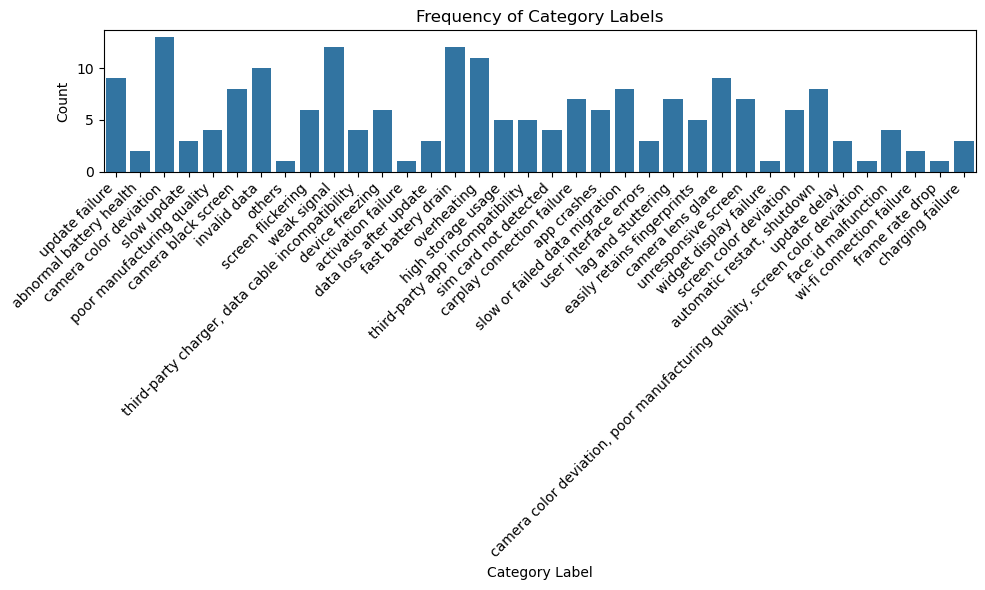

,summary
category,
abnormal battery health,2
activation failure,1
app crashes,6
"automatic restart, shutdown",8
camera black screen,8
camera color deviation,13
"camera color deviation, poor manufacturing quality, screen color deviation",1
camera lens glare,9
carplay connection failure,7


In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=results[['category']])
plt.title('Frequency of Category Labels')
plt.xlabel('Category Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

statistic_label = results.pivot_table(index='category',aggfunc='count')
statistic_label[['summary']]

### 5.1 Define system prompt and user prompt template
- we add instruction to generate report in certain content agenda as:
```markdown
# Executive Summary
Provide a brief overview of the report, summarizing key findings, conclusions, and recommendations. This section should be concise, allowing readers to grasp the main points quickly.

# Data Presentation
Data Overview: Provide a summary of the datasets used, including key metrics and attributes.
Key Performance Indicators (KPIs): Highlight the KPIs that are critical to the analysis.

# Findings
Present the results of the analysis in a structured manner:
Descriptive Statistics: Summarize the main characteristics of the data.
Trends and Patterns: Discuss any significant trends or patterns identified.
Comparative Analysis: If applicable, compare different datasets or time periods.

# Discussion
Interpret the findings in the context of the initial questions posed in the introduction.
Discuss the implications of the results, including potential impacts on business strategies or operations.
Address any unexpected results or anomalies.

# Conclusions
Summarize the key insights derived from the analysis.
Restate the significance of the findings in relation to the report’s objectives.

# Recommendations
Provide actionable recommendations based on the findings. These should be specific and feasible, guiding stakeholders on the next steps.
```

- And add additional context of statistic data in json


In [11]:
user = """
You are a data analysis expert in the retail industry
Your task is to analyze the given data and write a data analysis report. Follow these instructions:

- instructions:
- Transform the data into natural language, including all key data points as much as possible
- Only provide the final narrative report, do not show any intermediate analysis steps or processes
- Give insights and interpretations about the data in your narrative|
- the report should follow the content agenda as below:

# Executive Summary
Provide a brief overview of the report, summarizing key findings, conclusions, and recommendations. 
This section should be concise, no more than 100 words.

# Data Presentation
Data Overview: Provide a summary of the datasets used, including key metrics and attributes.
Key Performance Indicators (KPIs): Highlight the KPIs that are critical to the analysis.

# Findings
Present the results of the analysis in a structured manner:
Descriptive Statistics: Summarize the main characteristics of the data.
Trends and Patterns: Discuss any significant trends or patterns identified.
Comparative Analysis: If applicable, compare different datasets or time periods.

# Discussion
Interpret the findings in the context of the initial questions posed in the introduction.
Discuss the implications of the results, including potential impacts on business strategies or operations.
Address any unexpected results or anomalies.

# Conclusions
Summarize the key insights derived from the analysis.
Restate the significance of the findings in relation to the report’s objectives.

# Recommendations
Provide actionable recommendations based on the findings. These should be specific and feasible, guiding stakeholders on the next steps.


Here is the tabular data in json to analyze:
{tabular}

Here are the statistic data in json:
{statistic}

Please generate the report in markdown format:
"""

- Create a langchain chat template

In [12]:
prompt_advanced_1 = ChatPromptTemplate([
    ('user',user),
    ])
chain_advanced = prompt_advanced_1 | llm | StrOutputParser()

- convert the tabular data and statistic to json string and pass them to llm

In [13]:
response_advanced = ''
for chunk in chain_advanced.stream({"tabular":results.to_json(),
                          'statistic':statistic_label['summary'].to_json()}):
    print(colored(chunk,"green"),end='',flush=True)
    response_advanced += chunk

# Executive Summary
This report analyzes user feedback and statistics related to various issues with smartphones and laptops. Key findings include frequent issues with camera quality, battery health, and software updates. Recommendations focus on improving software stability, enhancing camera performance, and addressing overheating concerns.

# Data Presentation
## Data Overview
The datasets include user feedback and statistics on various issues with smartphones and laptops. Key metrics include the frequency of issues such as camera color deviation, battery drain, and software update failures.

## Key Performance Indicators (KPIs)
- Camera color deviation
- Battery health
- Software update success rate
- Device overheating incidents
- Signal strength consistency

# Findings
## Descriptive Statistics
The analysis reveals that the most common issues reported are camera color deviation (13 instances), fast battery drain (12 instances), and software update failures (9 instances). Other sig

### 5.2 Display the report in markdown

In [14]:
from IPython.display import Markdown, display,HTML
display(Markdown(response_advanced))

# Executive Summary
This report analyzes user feedback and statistics related to various issues with smartphones and laptops. Key findings include frequent issues with camera quality, battery health, and software updates. Recommendations focus on improving software stability, enhancing camera performance, and addressing overheating concerns.

# Data Presentation
## Data Overview
The datasets include user feedback and statistics on various issues with smartphones and laptops. Key metrics include the frequency of issues such as camera color deviation, battery drain, and software update failures.

## Key Performance Indicators (KPIs)
- Camera color deviation
- Battery health
- Software update success rate
- Device overheating incidents
- Signal strength consistency

# Findings
## Descriptive Statistics
The analysis reveals that the most common issues reported are camera color deviation (13 instances), fast battery drain (12 instances), and software update failures (9 instances). Other significant issues include overheating (11 instances) and weak signal (12 instances).

## Trends and Patterns
- Camera-related issues, such as color deviation and black screens, are prevalent.
- Battery-related problems, including fast drain and abnormal health, are frequently reported.
- Software update issues, including failures and delays, are common.
- Overheating is a significant concern, particularly during photo-taking.

## Comparative Analysis
Comparing different datasets or time periods is not applicable in this analysis as the data is cross-sectional.

# Discussion
Interpreting the findings in the context of the initial questions posed, it is evident that camera performance and battery health are critical areas needing improvement. The high frequency of software update issues suggests a need for more robust testing and quality assurance processes. The overheating problems, especially during photo-taking, indicate potential hardware or software inefficiencies that need addressing.

The implications of these results suggest that focusing on improving software stability, enhancing camera performance, and addressing overheating concerns could significantly improve user satisfaction. Unexpected results, such as the high number of camera-related issues, highlight the need for more rigorous testing in this area.

# Conclusions
The key insights derived from the analysis highlight significant issues with camera performance, battery health, and software updates. These findings are crucial for improving product quality and user satisfaction. The significance of these findings lies in their potential to guide future product development and quality assurance efforts.

# Recommendations
- Enhance software update processes to reduce failures and delays.
- Improve camera performance through better hardware and software calibration.
- Address overheating issues, particularly during photo-taking, to ensure user safety and comfort.
- Optimize battery health and performance to reduce instances of fast battery drain.
- Conduct thorough testing and quality assurance to minimize manufacturing defects and software bugs.